In [1]:
import numpy as np
import pandas as pd

results05 = np.loadtxt('Branin05')
resultsIsolated = np.loadtxt('BraninIsolated')
resultsRandom = np.loadtxt('BraninRandom')
resultsBest = np.loadtxt('Branin_best')
resultsBestSimAnneal = np.loadtxt('braninBestSimAnneal')
resultsbraninIsolatedSimAnneal = np.loadtxt('braninIsolatedSimAnneal')

In [2]:
global df

def ArraytoDF(resultsArray, methodName):
    
    df = pd.DataFrame(columns=['ExperimentNo', 'Iteration', 'Accuracy', 'Method'])   
    
    for i in range(21):
        for j in range(21):
            df = df.append({'ExperimentNo':i+1, 'Iteration':j+1, 'Accuracy':resultsArray[i][j]*100, 'Method':methodName}, ignore_index=True)
        
    
    return df

In [3]:
Results_DF = [ArraytoDF(results05, 'Exploitation (p=0.5)'),
              ArraytoDF(resultsIsolated, 'Exploration (Most Isolated)'),
              ArraytoDF(resultsRandom, 'Random Selection'),
              ArraytoDF(resultsBest, 'Best ( (0.5 - |0.5-p|) x d)'),
              ArraytoDF(resultsBestSimAnneal, 'Best + Simulated Annealing'),
              ArraytoDF(resultsbraninIsolatedSimAnneal, 'Most Isolated + Simulated Annealing')
              ]

In [16]:
Results_DF[(Results_DF['Iteration'] == 1)]['Accuracy'].median()

51.85390149418926

In [17]:
Results_DF[(Results_DF['Iteration'] == 21)]['Accuracy'].median()

84.4201561827461

In [34]:
(Results_DF[(Results_DF['Iteration'] == 21)&(Results_DF['Method'] == 'Exploitation (p=0.5)')]['Accuracy'].quantile(0.75))-(Results_DF[(Results_DF['Iteration'] == 21)&(Results_DF['Method'] == 'Exploitation (p=0.5)')]['Accuracy'].quantile(0.25))

16.81731537846646

66.87880464858881

In [4]:
Results_DF = pd.concat(Results_DF)

In [5]:
testin = Results_DF[(Results_DF['Iteration'] == 1)|(Results_DF['Iteration'] == 6)|(Results_DF['Iteration'] == 11)|(Results_DF['Iteration'] == 16)|(Results_DF['Iteration'] == 21)]

In [6]:
import numpy as np
from matplotlib.patches import PathPatch

def adjust_box_widths(g, fac):
    """
    Adjust the widths of a seaborn-generated boxplot.
    """

    # iterating through Axes instances
    for ax in g.axes:

        # iterating through axes artists:
        for c in ax.get_children():

            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                xmin = np.min(verts_sub[:, 0])
                xmax = np.max(verts_sub[:, 0])
                xmid = 0.5*(xmin+xmax)
                xhalf = 0.5*(xmax - xmin)

                # setting new width of box
                xmin_new = xmid-fac*xhalf
                xmax_new = xmid+fac*xhalf
                verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
                verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

                # setting new width of median line
                for l in ax.lines:
                    if np.all(l.get_xdata() == [xmin, xmax]):
                        l.set_xdata([xmin_new, xmax_new])

<ipython-input-6-a77ef4e19432>:34: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if np.all(l.get_xdata() == [xmin, xmax]):


Text(0, 0.5, 'Accuracy (%)')

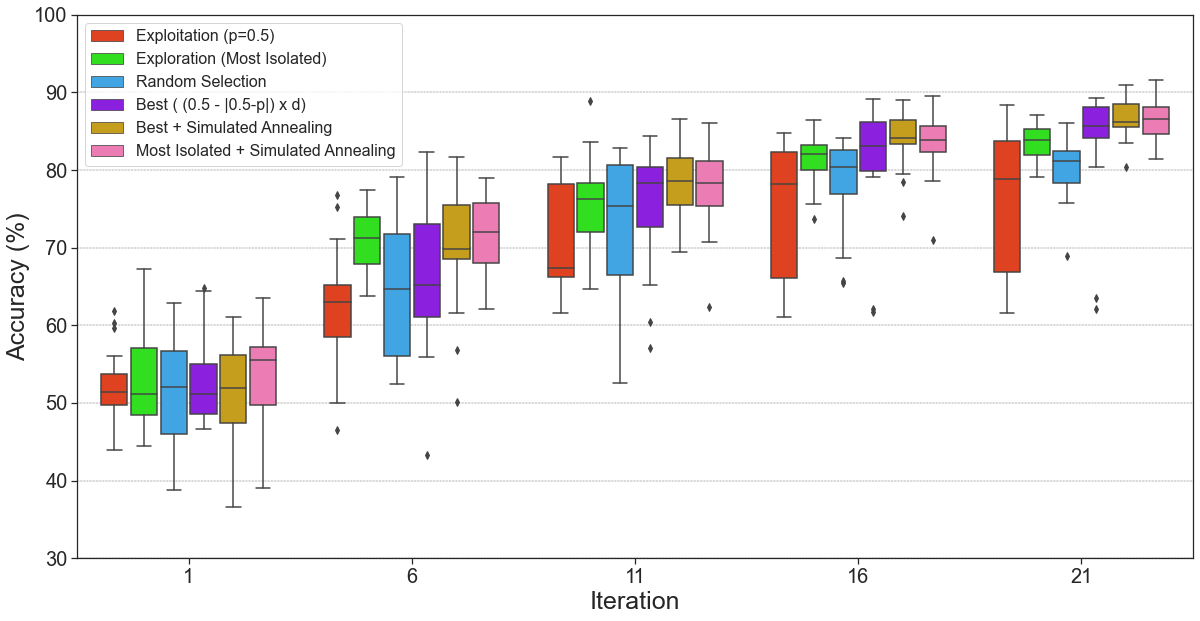

In [7]:
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pylab as pylab
sns.set_theme(style="ticks", palette="pastel")

# Load the example tips dataset
data = testin
palette = {'Exploitation (p=0.5)': '#ff2d00', 'Exploration (Most Isolated)': '#18ff00','Random Selection': '#26abff',
           'Best ( (0.5 - |0.5-p|) x d)': '#9000ff','Best + Simulated Annealing': '#e1ad01','Most Isolated + Simulated Annealing': '#ff69b4'}
# Draw a nested boxplot to show bills by day and time

fig, ax = pyplot.subplots(figsize=(20,10))
plt = sns.boxplot(x="Iteration", y="Accuracy",data=data,
            hue="Method", palette=palette, ax=ax)
ax.set(ylim=(30,100))

plt.legend(loc=0, prop={'size': 16})

plt.axis

adjust_box_widths(fig, 0.9)

ax.xaxis.label.set_size(25)
ax.yaxis.label.set_size(25)
plt.grid(axis = 'y', color = 'black', linestyle = '-.', linewidth = 0.3)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_ylabel('Accuracy (%)')


No handles with labels found to put in legend.


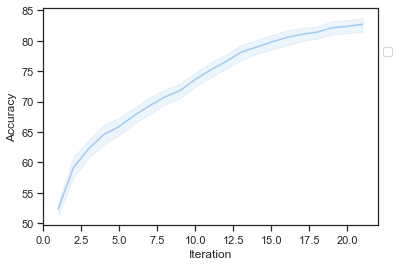

In [15]:
data = Results_DF

ax1 = sns.lineplot(x='Iteration', y='Accuracy', data=data, palette=palette)
ax1.legend(loc='center left', bbox_to_anchor=(1, .8), ncol=1)


In [9]:
import statistics
from scipy.stats import median_absolute_deviation, wilcoxon
from statsmodels.stats.multitest import multipletests

def wilcoxon_holm_eq_check(best_median_i, best_res):
    p_values = []
    #Gather the p-values for best med and other res from wilcoxon
    for i in range(len(best_res)):
        if i != best_median_i:
            _, p_value = wilcoxon(best_res[best_median_i], best_res[i])
            p_values.append(p_value)
        else:
            p_values.append(0)
    #holm correction
    reject, p_val_holm,_,_ = multipletests(p_values,alpha=0.1,method="holm")
    return reject

medians = (statistics.median([el[20] for el in results05]),
           statistics.median([el[20] for el in resultsIsolated]),
           statistics.median([el[20] for el in resultsRandom]),
           statistics.median([el[20] for el in resultsBest]),
           statistics.median([el[20] for el in resultsBestSimAnneal]),
           statistics.median([el[20] for el in resultsbraninIsolatedSimAnneal]))

best_median = max(medians)
best_median_i = medians.index((best_median))

best_res = ([el[20] for el in results05],
           [el[20] for el in resultsIsolated],
           [el[20] for el in resultsRandom],
           [el[20] for el in resultsBest],
           [el[20] for el in resultsBestSimAnneal],
           [el[20] for el in resultsbraninIsolatedSimAnneal])

print('medians list:', medians)
print('best_median_i:',best_median_i)
print(best_res)
print('best_res shape:', len(best_res), '*', len(best_res[0]))
print('result = ', wilcoxon_holm_eq_check(best_median_i, best_res))



medians list: (0.7883231876037632, 0.8384369427534896, 0.8121195351411179, 0.856945213060321, 0.8622640349259054, 0.8661795808498366)
best_median_i: 5
([0.83142716595954, 0.8273073848613417, 0.8169771874807846, 0.8553157474020784, 0.6687880464858882, 0.8638627559490869, 0.6589805079013712, 0.8369612002705528, 0.8186066531390273, 0.6767509069667343, 0.7883231876037632, 0.6762897374408166, 0.6643915636721393, 0.6820389841972576, 0.6260222591157842, 0.6669741130172785, 0.8835393223882433, 0.6155690831949825, 0.8384984320236119, 0.6907704605546332, 0.8613109512390088], [0.8496279899157597, 0.8047408227264342, 0.8534403246633463, 0.8592203160548484, 0.8227264342372256, 0.8384369427534896, 0.8554694705773842, 0.8515034126544918, 0.8324109942814979, 0.8197442046362909, 0.8183299514234766, 0.8157474020783373, 0.8669064748201439, 0.8707495542027917, 0.8585439340835024, 0.8419725757855254, 0.7915513742851872, 0.8285371702637889, 0.8241714320851011, 0.8196827153661687, 0.8504273504273504], [0.812